In [3]:
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
print("GPU:", "Available" if tf.config.list_physical_devices('GPU') else "Not Available")

GPU: Available


In [5]:
from tensorflow.keras.datasets import  cifar10

In [6]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [7]:
class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse",	"ship",	"truck"]

# MobilenetV2

In [8]:
Img_size = 224
Batch_size = 64

In [9]:
# One-hot encode labels
y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)

# Define resize size (e.g. 224 for MobileNetV2)
IMG_SIZE = 224
BATCH_SIZE = 16  # adjust based on your GPU RAM

# Create tf.data datasets
X_train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train_cat))
X_test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test_cat))

# Preprocessing function
def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))  # resize to (224,224)
    image = preprocess_input(image)                       # MobileNetV2 preprocess
    return image, label

# Apply preprocessing + batching + prefetching
X_train_ds = X_train_ds.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
X_test_ds  = X_test_ds.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


I0000 00:00:1756474488.889546   79758 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1767 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [10]:
for images, labels in X_train_ds.take(1):
    print(images.shape)
    print(labels.shape)

(16, 224, 224, 3)
(16, 10)


2025-08-29 15:34:50.439570: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


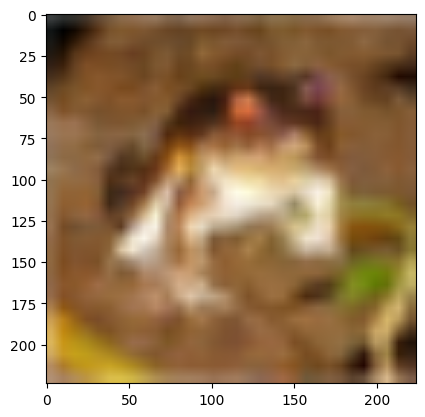

In [11]:
import matplotlib.pyplot as plt

for images, labels in X_train_ds.take(1):
    plt.imshow((images[0].numpy() + 1) / 2)  # MobileNet preprocess_input scales pixels
    plt.show()
    break

In [12]:
# Build transfer learning model
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze base

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 9s 1us/step


### Adam 

In [13]:
model_adam = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(), # Pool spatial features into a vector
    layers.Dense(128, activation='relu'), # Fully connected layer to learn new patterns
    layers.Dropout(0.3),
    layers.Dense(10, activation='softmax')

])

In [14]:
model_adam.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [16]:
history_adam_mobnet = model_adam.fit(X_train_ds,validation_data=X_test_ds, epochs=10, callbacks= ModelCheckpoint(filepath='mobilenet_adam_bm.keras',monitor='val_loss',
    save_best_only=True,mode='min',verbose=1))

Epoch 1/10


2025-08-29 15:35:10.868912: I external/local_xla/xla/service/service.cc:163] XLA service 0x782a5c0108f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-08-29 15:35:10.868967: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2025-08-29 15:35:11.037336: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-08-29 15:35:12.402049: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91200
2025-08-29 15:35:27.190599: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-08-29 15:35:27.498380: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel 

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7288 - loss: 0.8078
Epoch 1: val_loss improved from None to 0.46425, saving model to mobilenet_adam_bm.keras
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 135s 34ms/step - accuracy: 0.7805 - loss: 0.6503 - val_accuracy: 0.8386 - val_loss: 0.4643
Epoch 2/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8196 - loss: 0.5276
Epoch 2: val_loss improved from 0.46425 to 0.44413, saving model to mobilenet_adam_bm.keras
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 100s 32ms/step - accuracy: 0.8254 - loss: 0.5135 - val_accuracy: 0.8453 - val_loss: 0.4441
Epoch 3/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8336 - loss: 0.4791
Epoch 3: val_loss improved from 0.44413 to 0.43756, saving model to mobilenet_adam_bm.keras
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 101s 32ms/step - accuracy: 0.8368 - loss: 0.4724 - val_accuracy: 0.8490 - val_loss: 0.4376
Epoch 4/10
3123/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8465 - loss: 0.4494
Epoch 4: val_los

### SGD

In [17]:
model_sgd = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(), # Pool spatial features into a vector
    layers.Dense(128, activation='relu'), # Fully connected layer to learn new patterns
    layers.Dropout(0.3),
    layers.Dense(10, activation='softmax')
])

In [18]:
model_sgd.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
history_sgd_mobnet = model_sgd.fit(X_train_ds,validation_data=X_test_ds, epochs=10, callbacks= ModelCheckpoint(filepath='mobnet_sgd_bm.keras',monitor='val_loss',
    save_best_only=True,mode='min',verbose=1))

Epoch 1/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6980 - loss: 0.8859
Epoch 1: val_loss improved from None to 0.48952, saving model to mobnet_sgd_bm.keras
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 121s 34ms/step - accuracy: 0.7668 - loss: 0.6809 - val_accuracy: 0.8310 - val_loss: 0.4895
Epoch 2/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8220 - loss: 0.5215
Epoch 2: val_loss improved from 0.48952 to 0.44943, saving model to mobnet_sgd_bm.keras
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 102s 32ms/step - accuracy: 0.8272 - loss: 0.5059 - val_accuracy: 0.8445 - val_loss: 0.4494
Epoch 3/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.8410 - loss: 0.4655
Epoch 3: val_loss improved from 0.44943 to 0.43256, saving model to mobnet_sgd_bm.keras
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 839s 268ms/step - accuracy: 0.8422 - loss: 0.4594 - val_accuracy: 0.8500 - val_loss: 0.4326
Epoch 4/10
3123/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8496 - loss: 0.4351
Epoch 4: val_lo

In [20]:
from tensorflow.keras.models import load_model

In [21]:
load_model_a = load_model('mobilenet_adam_bm.keras')
load_model_s = load_model('mobnet_sgd_bm.keras')

In [22]:
est_loss_a, test_acc_a = load_model_a.evaluate(X_test_ds)
print(f"Test Accuracy: {test_acc_a:.4f}")
print(f"Test Loss: {est_loss_a:.4f}")

625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - accuracy: 0.8490 - loss: 0.4376
Test Accuracy: 0.8490
Test Loss: 0.4376


In [23]:
est_loss_s, test_acc_s = load_model_s.evaluate(X_test_ds)
print(f"Test Accuracy: {test_acc_s:.4f}")
print(f"Test Loss: {est_loss_s:.4f}")

625/625 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - accuracy: 0.8620 - loss: 0.4071
Test Accuracy: 0.8620
Test Loss: 0.4071


In [24]:
# Predictions
y_pred_probs_a = load_model_a.predict(X_test_ds)
y_pred_a = np.argmax(y_pred_probs_a, axis=1)

625/625 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step


In [25]:
# Predictions
y_pred_probs_s = load_model_s.predict(X_test_ds)
y_pred_s = np.argmax(y_pred_probs_s, axis=1)

625/625 ━━━━━━━━━━━━━━━━━━━━ 24s 23ms/step


In [26]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred_a, target_names=class_names)
print(report)

              precision    recall  f1-score   support

    airplane       0.90      0.82      0.86      1000
  automobile       0.93      0.92      0.92      1000
        bird       0.81      0.80      0.81      1000
         cat       0.71      0.76      0.74      1000
        deer       0.83      0.80      0.81      1000
         dog       0.87      0.75      0.81      1000
        frog       0.85      0.89      0.87      1000
       horse       0.81      0.90      0.85      1000
        ship       0.87      0.93      0.90      1000
       truck       0.92      0.92      0.92      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



In [27]:
report = classification_report(y_test, y_pred_s, target_names=class_names)
print(report)

              precision    recall  f1-score   support

    airplane       0.90      0.86      0.88      1000
  automobile       0.92      0.93      0.92      1000
        bird       0.81      0.86      0.83      1000
         cat       0.77      0.74      0.75      1000
        deer       0.84      0.83      0.83      1000
         dog       0.83      0.81      0.82      1000
        frog       0.90      0.87      0.88      1000
       horse       0.83      0.90      0.86      1000
        ship       0.90      0.93      0.91      1000
       truck       0.93      0.91      0.92      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



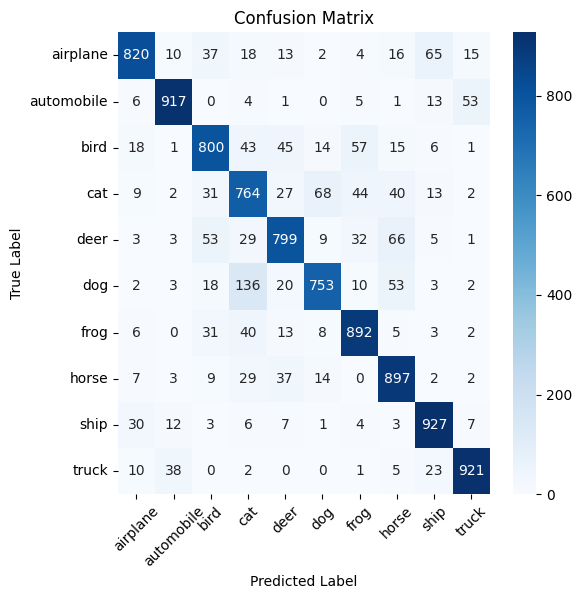

In [28]:
cm = confusion_matrix(y_test, y_pred_a)

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()


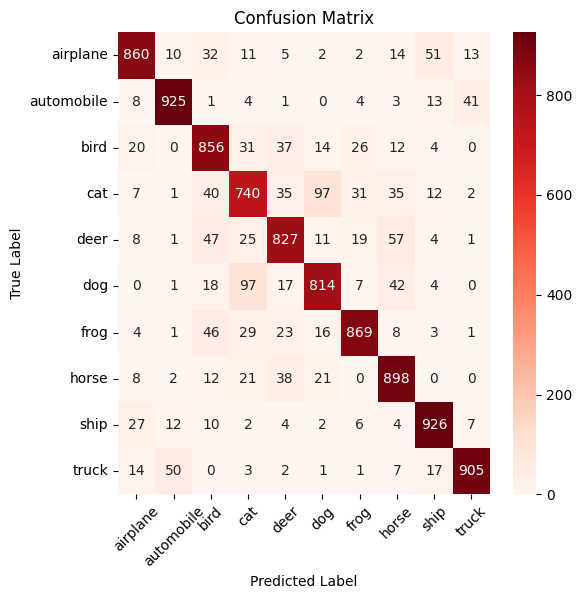

In [29]:
cm = confusion_matrix(y_test, y_pred_s)

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()


In [30]:
# base_model.trainable = True

# # Freeze all layers except the last N (e.g., last 20 layers)
# fine_tune_at = len(base_model.layers) - 20
# for layer in base_model.layers[:fine_tune_at]:
#     layer.trainable = False
base_model.trainable = True
for layer in base_model.layers[:-15]:  # keep most layers frozen, fine-tune last 30
    layer.trainable = False

In [31]:
from tensorflow.keras import optimizers

#### Fine tuning

In [32]:
load_model_a.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Continue training (fine-tuning)
fine_tune_epochs = 8
total_epochs = 3 + fine_tune_epochs  # if trained earlier 3 epochs

history_fine_a_mobnet = load_model_a.fit(
    X_train_ds,
    validation_data=X_test_ds,
    epochs=total_epochs,
    initial_epoch=3,callbacks= ModelCheckpoint(filepath='mobnetfintun_a_bm.keras',monitor='val_loss',
    save_best_only=True,mode='min',verbose=1))


Epoch 4/11


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8554 - loss: 0.4224
Epoch 4: val_loss improved from None to 0.42025, saving model to mobnetfintun_a_bm.keras
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 131s 37ms/step - accuracy: 0.8641 - loss: 0.3954 - val_accuracy: 0.8561 - val_loss: 0.4203
Epoch 5/11
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8660 - loss: 0.3919
Epoch 5: val_loss improved from 0.42025 to 0.41673, saving model to mobnetfintun_a_bm.keras
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 94s 30ms/step - accuracy: 0.8704 - loss: 0.3754 - val_accuracy: 0.8566 - val_loss: 0.4167
Epoch 6/11
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8672 - loss: 0.3823
Epoch 6: val_loss improved from 0.41673 to 0.41595, saving model to mobnetfintun_a_bm.keras
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 97s 31ms/step - accuracy: 0.8719 - loss: 0.3697 - val_accuracy: 0.8587 - val_loss: 0.4160
Epoch 7/11
3124/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8673 - loss: 0.3808
Epoch 7: val_loss 

In [33]:
load_model_s.compile(
    optimizer=optimizers.SGD(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Continue training (fine-tuning)
fine_tune_epochs = 12
total_epochs = 6 + fine_tune_epochs  # if trained earlier 3 epochs

history_fine_s_mobnet = load_model_s.fit(
    X_train_ds,
    validation_data=X_test_ds,
    epochs=total_epochs,
    initial_epoch=3,callbacks= ModelCheckpoint(filepath='mobnetfintun_s_bm.keras',monitor='val_loss',
    save_best_only=True,mode='min',verbose=1))

Epoch 4/18


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8842 - loss: 0.3258
Epoch 4: val_loss improved from None to 0.40419, saving model to mobnetfintun_s_bm.keras
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 122s 35ms/step - accuracy: 0.8876 - loss: 0.3172 - val_accuracy: 0.8624 - val_loss: 0.4042
Epoch 5/18
3124/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8857 - loss: 0.3254
Epoch 5: val_loss improved from 0.40419 to 0.40229, saving model to mobnetfintun_s_bm.keras
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 103s 33ms/step - accuracy: 0.8899 - loss: 0.3151 - val_accuracy: 0.8634 - val_loss: 0.4023
Epoch 6/18
3123/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8874 - loss: 0.3226
Epoch 6: val_loss improved from 0.40229 to 0.40094, saving model to mobnetfintun_s_bm.keras
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 101s 32ms/step - accuracy: 0.8911 - loss: 0.3122 - val_accuracy: 0.8639 - val_loss: 0.4009
Epoch 7/18
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8872 - loss: 0.3204
Epoch 7: val_los

In [34]:
load_a_bm = load_model('mobnetfintun_a_bm.keras')
load_s_bm = load_model('mobnetfintun_s_bm.keras')

In [35]:
test_loss_fntun, test_acc_fntun = load_a_bm.evaluate(X_test_ds)
print(f"Test Accuracy after fine-tuning: {test_acc_fntun:.4f}")
print(f"Test Loss after fine-tuning: {test_loss_fntun:.4f}")

625/625 ━━━━━━━━━━━━━━━━━━━━ 32s 26ms/step - accuracy: 0.8587 - loss: 0.4115
Test Accuracy after fine-tuning: 0.8587
Test Loss after fine-tuning: 0.4115


In [36]:
test_loss_fntun, test_acc_fntun = load_s_bm.evaluate(X_test_ds)
print(f"Test Accuracy after fine-tuning: {test_acc_fntun:.4f}")
print(f"Test Loss after fine-tuning: {test_loss_fntun:.4f}")

625/625 ━━━━━━━━━━━━━━━━━━━━ 26s 27ms/step - accuracy: 0.8646 - loss: 0.3963
Test Accuracy after fine-tuning: 0.8646
Test Loss after fine-tuning: 0.3963


In [37]:
y_pred_probs_a_fntun = load_a_bm.predict(X_test_ds)
y_pred_a_fntn = np.argmax(y_pred_probs_a_fntun, axis=1)

625/625 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step


In [38]:
y_pred_probs_s_fntun = load_s_bm.predict(X_test_ds)
y_pred_s_fntn = np.argmax(y_pred_probs_s_fntun, axis=1)

625/625 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step


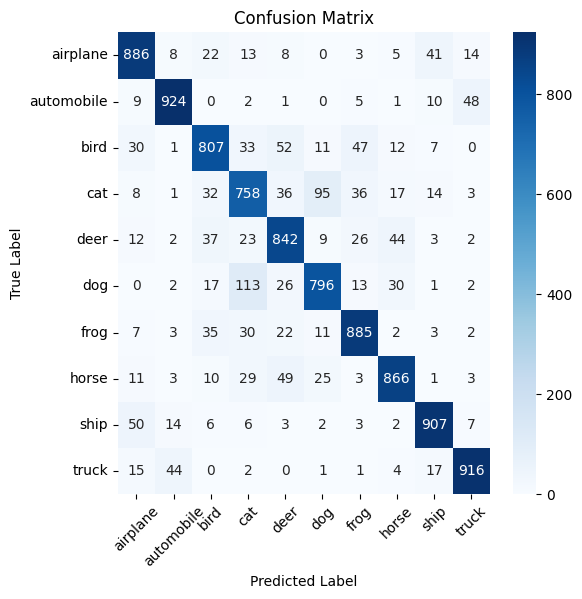

In [39]:
cm = confusion_matrix(y_test, y_pred_a_fntn)

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

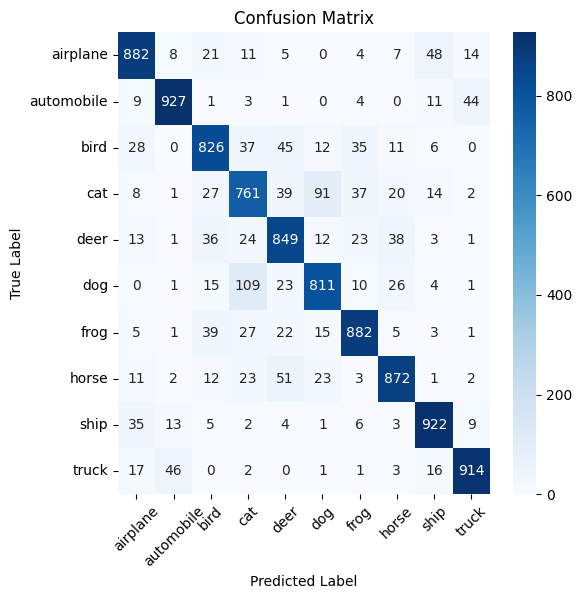

In [40]:
cm = confusion_matrix(y_test, y_pred_s_fntn)

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

# DenseNet121

In [41]:
from tensorflow.keras.applications import DenseNet121

In [42]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.densenet import preprocess_input as ppi

# One-hot encode labels
y_train_cat_densenet = to_categorical(y_train, 10)
y_test_cat_densenet = to_categorical(y_test, 10)

# Define resize size (DenseNet expects 224x224 typically)
IMG_SIZE = 224
BATCH_SIZE = 16  # adjust based on GPU RAM

# Create tf.data datasets
X_train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train_cat_densenet))
X_test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test_cat_densenet))

# Preprocessing function
def preprocess_densenet(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))  # resize to (224,224)
    image = ppi(image)
    return image, label

# Apply preprocessing + batching + prefetching
X_train_ds = X_train_ds.map(preprocess_densenet).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
X_test_ds  = X_test_ds.map(preprocess_densenet).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [43]:
# Build DenseNet-121 base
base_model_dense = DenseNet121(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                         include_top=False,
                         weights="imagenet")
base_model_dense.trainable = False  # freeze base initially

# Add custom head
model_densenet = models.Sequential([
    base_model_dense,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),                  # prevent overfitting
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')
])

# Compile
model_densenet.compile(optimizer= optimizers.Adam(learning_rate=1e-4),
                       loss="categorical_crossentropy",
                       metrics=["accuracy"])

# Train
history_densenet = model_densenet.fit(
    X_train_ds,
    validation_data= X_test_ds,
    epochs=10,
    verbose=1,
    callbacks= ModelCheckpoint(filepath='densenet_a_bm.keras',monitor='val_loss',
    save_best_only=True,mode='min',verbose=1)
)

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.5521 - loss: 1.3338
Epoch 1: val_loss improved from None to 0.42218, saving model to densenet_a_bm.keras
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 303s 81ms/step - accuracy: 0.6947 - loss: 0.8972 - val_accuracy: 0.8568 - val_loss: 0.4222
Epoch 2/10
3124/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.7973 - loss: 0.5840
Epoch 2: val_loss improved from 0.42218 to 0.38465, saving model to densenet_a_bm.keras
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 235s 75ms/step - accuracy: 0.8006 - loss: 0.5734 - val_accuracy: 0.8671 - val_loss: 0.3847
Epoch 3/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.8128 - loss: 0.5428
Epoch 3: val_loss improved from 0.38465 to 0.36959, saving model to densenet_a_bm.keras
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 210s 67ms/step - accuracy: 0.8130 - loss: 0.5401 - val_accuracy: 0.8734 - val_loss: 0.3696
Epoch 4/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step 

KeyboardInterrupt: 

In [ ]:
load_a_densnet = load_model("densenet_a_bm.keras")

In [ ]:
test_loss_densnet, test_acc_densnet = load_a_densnet.evaluate(X_train_ds)
print(f"Test Accuracy after fine-tuning: {test_acc_densnet:.4f}")
print(f"Test Loss after fine-tuning: {test_loss_densnet:.4f}")

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 130s 42ms/step - accuracy: 0.8921 - loss: 0.3214
Test Accuracy after fine-tuning: 0.8934
Test Loss after fine-tuning: 0.3187


In [ ]:
test_loss_densnet, test_acc_densnet = load_a_densnet.evaluate(X_test_ds)
print(f"Test Accuracy after fine-tuning: {test_acc_densnet:.4f}")
print(f"Test Loss after fine-tuning: {test_loss_densnet:.4f}")

625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 40ms/step - accuracy: 0.8841 - loss: 0.3465
Test Accuracy after fine-tuning: 0.8842
Test Loss after fine-tuning: 0.3457


In [ ]:
# Build DenseNet-121 base
base_model_dense = DenseNet121(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                         include_top=False,
                         weights="imagenet")
base_model_dense.trainable = False  # freeze base initially

# Add custom head
model_densenet_sgd = models.Sequential([
    base_model_dense,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),                  # prevent overfitting
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')
])

# Compile
model_densenet_sgd.compile(optimizer= optimizers.SGD(learning_rate=1e-4),
                       loss="categorical_crossentropy",
                       metrics=["accuracy"])

# Train
history_densenet_sgd = model_densenet_sgd.fit(
    X_train_ds,
    validation_data= X_test_ds,
    epochs=10,
    verbose=1,
    callbacks= ModelCheckpoint(filepath='densenet_s_bm.keras',monitor='val_loss',
    save_best_only=True,mode='min',verbose=1)
)

Epoch 1/10
3124/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.1721 - loss: 2.5934
Epoch 1: val_loss improved from inf to 1.56086, saving model to densenet_s_bm.keras
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 185s 52ms/step - accuracy: 0.1721 - loss: 2.5932 - val_accuracy: 0.5355 - val_loss: 1.5609
Epoch 2/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.3754 - loss: 1.7849
Epoch 2: val_loss improved from 1.56086 to 1.17967, saving model to densenet_s_bm.keras
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 194s 53ms/step - accuracy: 0.3754 - loss: 1.7849 - val_accuracy: 0.6696 - val_loss: 1.1797
Epoch 3/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5000 - loss: 1.4479
Epoch 3: val_loss improved from 1.17967 to 0.96476, saving model to densenet_s_bm.keras
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 185s 48ms/step - accuracy: 0.5000 - loss: 1.4479 - val_accuracy: 0.7250 - val_loss: 0.9648
Epoch 4/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5725 - loss: 1.2393
Epoch 4: val_loss 